In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import optuna
import csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e13/sample_submission.csv
/kaggle/input/playground-series-s3e13/train.csv
/kaggle/input/playground-series-s3e13/test.csv


In [20]:
TRAIN_PATH = '/kaggle/input/playground-series-s3e13/train.csv'
TEST_PATH = '/kaggle/input/playground-series-s3e13/test.csv'

In [21]:
def apk(actual, predicted, k=3):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(actual), k)

def mapk_score(y_true, y_pred, k=3):
    return np.mean([apk([a], p, k) for a, p in zip(y_true, y_pred)])

def to_optimize(trial):
    params = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000, step=500),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_val)
    
    top3_indices = np.argsort(probs, axis=1)[:, -3:]
    
    score = mapk_score(y_val, top3_indices, k=3)
    return score

In [22]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_test.head()

,id,sudden_fever,headache,mouth_bleed,nose_bleed,muscle_pain,joint_pain,vomiting,rash,diarrhea,...,lymph_swells,breathing_restriction,toe_inflammation,finger_inflammation,lips_irritation,itchiness,ulcers,toenail_loss,speech_problem,bullseye_rash
0,707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,708,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,709,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,710,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,711,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
test_ids = df_test['id']
df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

In [24]:
X = df_train.drop(columns=['prognosis'])
y = df_train['prognosis']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X = X.astype(int)
df_test = df_test.astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.3 
)

In [25]:
optim = optuna.create_study(direction='maximize')
optim.optimize(to_optimize, n_trials=30) 

best_params = optim.best_params
print("best params:")
print(best_params)

[I 2025-12-15 17:39:18,663] A new study created in memory with name: no-name-71d12dc5-44ec-482d-bb2e-e42e73aa251f
[I 2025-12-15 17:39:21,653] Trial 0 finished with value: 0.32942097026604067 and parameters: {'min_samples_split': 11, 'min_samples_leaf': 15, 'max_depth': 11, 'n_estimators': 2500, 'bootstrap': False}. Best is trial 0 with value: 0.32942097026604067.
[I 2025-12-15 17:39:24,242] Trial 1 finished with value: 0.3364632237871674 and parameters: {'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 7, 'n_estimators': 2000, 'bootstrap': False}. Best is trial 1 with value: 0.3364632237871674.
[I 2025-12-15 17:39:28,739] Trial 2 finished with value: 0.3568075117370892 and parameters: {'min_samples_split': 13, 'min_samples_leaf': 8, 'max_depth': 15, 'n_estimators': 3500, 'bootstrap': False}. Best is trial 2 with value: 0.3568075117370892.
[I 2025-12-15 17:39:32,232] Trial 3 finished with value: 0.3286384976525822 and parameters: {'min_samples_split': 12, 'min_samples_leaf': 

best params:
{'min_samples_split': 7, 'min_samples_leaf': 8, 'max_depth': 30, 'n_estimators': 2500, 'bootstrap': False}


In [26]:
final_params = best_params.copy()

model = RandomForestClassifier(**final_params)
model.fit(X, y_encoded)

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_leaf=8,
                       min_samples_split=7, n_estimators=2500)

In [27]:
preds = model.predict_proba(df_test)

top_preds = np.argsort(preds, axis=1)[:, -3:][:, ::-1]

top_prognosis = np.vectorize(lambda x: encoder.classes_[x])(top_preds)

final_predictions = [' '.join(prognosis) for prognosis in top_prognosis]

submission = pd.DataFrame({
    'id': test_ids,
    'prognosis': final_predictions
})

submission.to_csv('submission_baseline.csv', index=False)
submission.head()

,id,prognosis
0,707,Rift_Valley_fever Dengue Japanese_encephalitis
1,708,Dengue Chikungunya Rift_Valley_fever
2,709,West_Nile_fever Japanese_encephalitis Rift_Val...
3,710,Japanese_encephalitis Rift_Valley_fever West_N...
4,711,West_Nile_fever Malaria Japanese_encephalitis


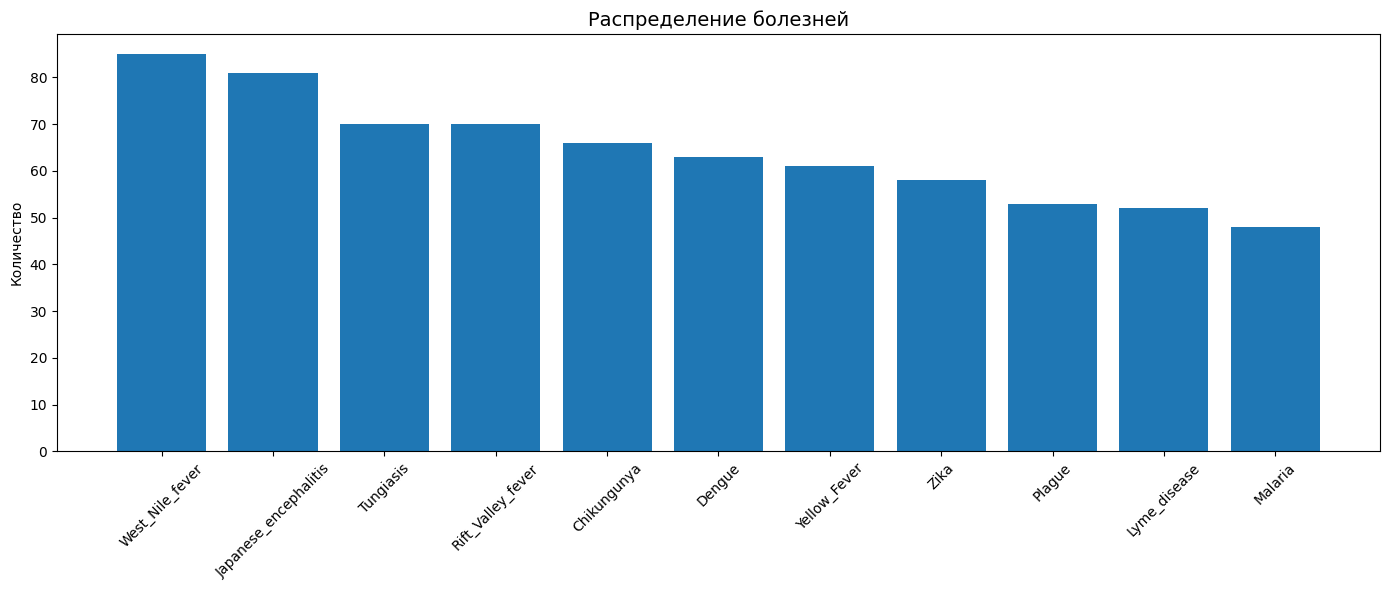

In [28]:
counts = df_train['prognosis'].value_counts()
labels = counts.index

_, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(labels, counts.values)
ax.set_title('Распределение болезней', fontsize=14)
ax.set_ylabel('Количество')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

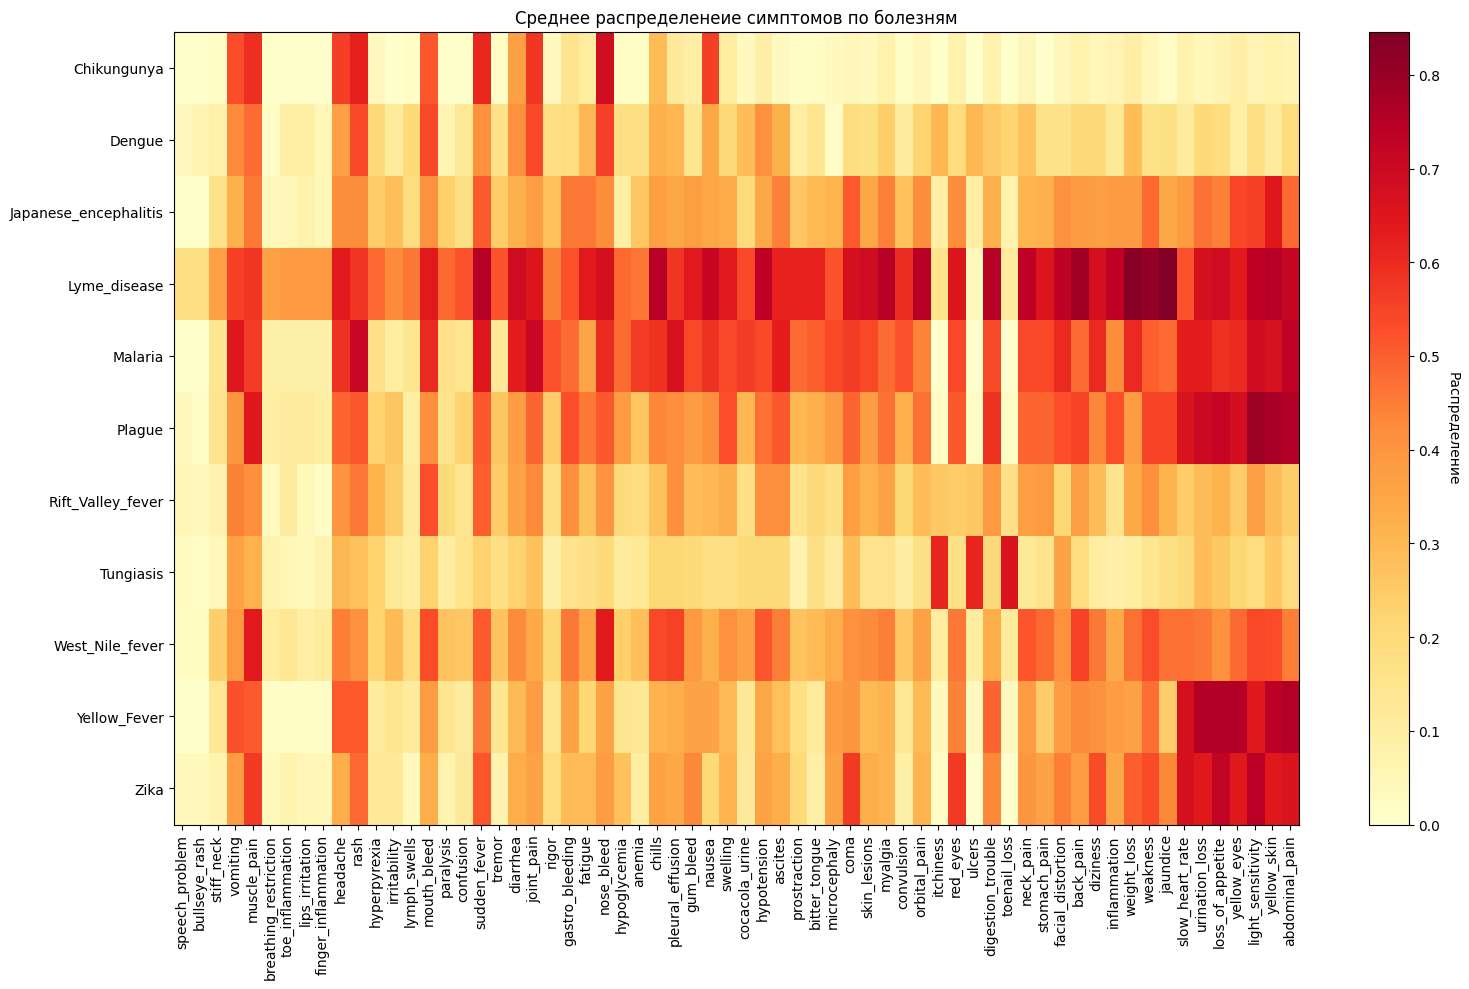

In [29]:
grouped_data = df_train.groupby('prognosis').mean()

variances = grouped_data.var().sort_values().index
heatmap_data = grouped_data[variances]

fig, ax = plt.subplots(figsize=(16, 10))
im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Распределение", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(heatmap_data.columns)))
ax.set_yticks(np.arange(len(heatmap_data.index)))
ax.set_xticklabels(heatmap_data.columns, rotation=90)
ax.set_yticklabels(heatmap_data.index)

ax.set_title('Среднее распределенеие симптомов по болезням')
ax.grid(False)
plt.tight_layout()
plt.show()

In [30]:
def add_group_features(df, group_config):
    df_out = df.copy()
    for group_name, columns in group_config.items():
        valid_cols = [c for c in columns if c in df_out.columns]
        df_out[group_name] = df_out[valid_cols].sum(axis=1)
    return df_out

In [31]:
SYMPTOM_GROUPS = {
    'similar_group': [
        'loss_of_appetite', 'urination_loss', 'slow_heart_rate', 
        'abdominal_pain', 'light_sensitivity', 'yellow_skin', 'yellow_eyes'
    ],
    'lyme_group': [
        'jaundice', 'weight_loss', 'weakness', 'back_pain',
        'sudden_fever', 'neck_pain', 'myalgia', 'chills',
        'orbital_pain', 'digestion_trouble', 'inflammation',
        'convulsion', 'hypotension'
    ],
    'tungiasis_group': [
        'ulcers', 'toenail_loss', 'itchiness'
    ],
    'chikungunya_group': [
        'convulsion', 'finger_inflammation', 'speech_problem', 'toenail_loss', 
        'ulcers', 'itchiness', 'lips_irritation', 'breathing_restriction', 
        'toe_inflammation', 'paralysis', 'stomach_pain', 'confusion', 
        'irritability', 'bullseye_rash', 'irritability',
        'anemia', 'hypoglycemia'
    ]
}

In [32]:
df_train = add_group_features(df_train, SYMPTOM_GROUPS)
df_test = add_group_features(df_test, SYMPTOM_GROUPS)

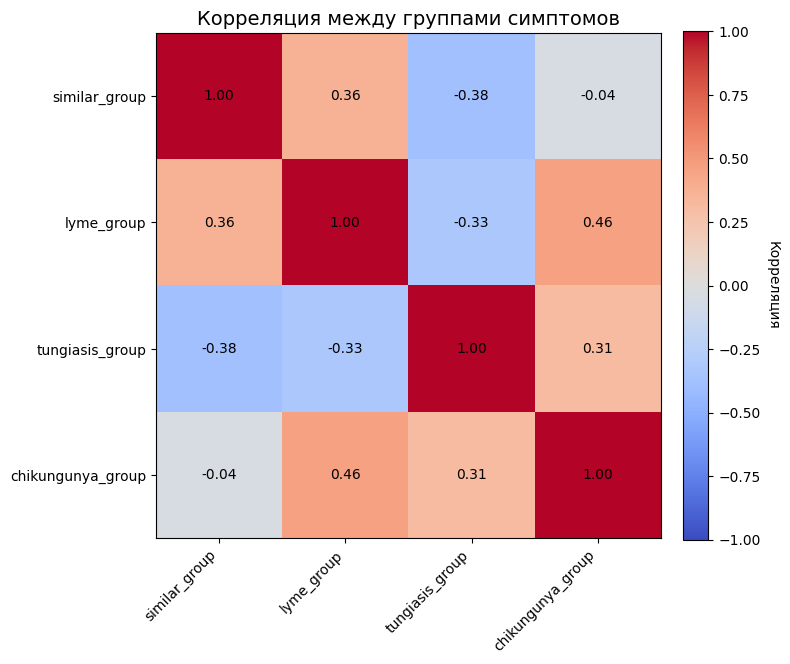

In [33]:
group_cols = list(SYMPTOM_GROUPS.keys())
corr_matrix = df_train[group_cols].corr()

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)

cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.set_ylabel("Корреляция", rotation=-90, va="bottom")

ax.set_xticks(np.arange(len(group_cols)))
ax.set_yticks(np.arange(len(group_cols)))
ax.set_xticklabels(group_cols, rotation=45, ha="right")
ax.set_yticklabels(group_cols)

for i in range(len(group_cols)):
    for j in range(len(group_cols)):
        text = ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax.set_title("Корреляция между группами симптомов", fontsize=14)
plt.tight_layout()
plt.show()

In [34]:
X = df_train.drop(columns=['prognosis'])
y = df_train['prognosis']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

X = X.astype(int)
df_test = df_test.astype(int)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.3 
)


In [35]:
optim = optuna.create_study(direction='maximize')
optim.optimize(to_optimize, n_trials=30) 

best_params = optim.best_params
print("best params:")
print(best_params)

[I 2025-12-15 17:41:07,956] A new study created in memory with name: no-name-bf512b58-fae6-40e4-9cfe-e2b2961b0fb0
[I 2025-12-15 17:41:09,795] Trial 0 finished with value: 0.33255086071987483 and parameters: {'min_samples_split': 9, 'min_samples_leaf': 13, 'max_depth': 35, 'n_estimators': 1500, 'bootstrap': False}. Best is trial 0 with value: 0.33255086071987483.
[I 2025-12-15 17:41:15,474] Trial 1 finished with value: 0.3794992175273866 and parameters: {'min_samples_split': 6, 'min_samples_leaf': 15, 'max_depth': 49, 'n_estimators': 4000, 'bootstrap': True}. Best is trial 1 with value: 0.3794992175273866.
[I 2025-12-15 17:41:16,177] Trial 2 finished with value: 0.36228482003129886 and parameters: {'min_samples_split': 17, 'min_samples_leaf': 18, 'max_depth': 39, 'n_estimators': 500, 'bootstrap': True}. Best is trial 1 with value: 0.3794992175273866.
[I 2025-12-15 17:41:18,655] Trial 3 finished with value: 0.3482003129890454 and parameters: {'min_samples_split': 8, 'min_samples_leaf': 1

best params:
{'min_samples_split': 15, 'min_samples_leaf': 16, 'max_depth': 24, 'n_estimators': 5000, 'bootstrap': True}


In [36]:
final_params = best_params.copy()

model = RandomForestClassifier(**final_params)
model.fit(X, y_encoded)

RandomForestClassifier(max_depth=24, min_samples_leaf=16, min_samples_split=15,
                       n_estimators=5000)

In [37]:
preds = model.predict_proba(df_test)

top_preds = np.argsort(preds, axis=1)[:, -3:][:, ::-1]

top_prognosis = np.vectorize(lambda x: encoder.classes_[x])(top_preds)

final_predictions = [' '.join(prognosis) for prognosis in top_prognosis]

submission = pd.DataFrame({
    'id': test_ids,
    'prognosis': final_predictions
})

In [38]:
submission.to_csv('submission.csv', index=False)
submission.head()

,id,prognosis
0,707,Chikungunya Japanese_encephalitis Zika
1,708,Chikungunya Dengue West_Nile_fever
2,709,West_Nile_fever Japanese_encephalitis Rift_Val...
3,710,Japanese_encephalitis Rift_Valley_fever Dengue
4,711,West_Nile_fever Japanese_encephalitis Zika
